In [7]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import unireps
import torch
import datasets
import matplotlib.pyplot as plt

# project_dir = '/Users/christopher/Documents/unireps'
project_dir = '/net/scratch2/chriswolfram/unireps'
unireps.set_hf_cache_directory(os.path.join(project_dir, 'hf_cache'))
unireps.set_datasets_directory(os.path.join(project_dir, 'datasets'))
unireps.set_outputs_directory(os.path.join(project_dir, 'outputs'))

datasets.disable_caching()

### Models

In [2]:
model_names = [
    "openai-community/gpt2",
    "google/gemma-2b",
    "google/gemma-7b",
    "google/gemma-2-2b",
    "google/gemma-2-9b",
    "google/gemma-2-9b-it",
    "google/gemma-2-27b",
    "meta-llama/Meta-Llama-3.1-8B",
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Llama-3.2-1B",
    "meta-llama/Llama-3.2-3B",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.2-11B-Vision",
    "mistralai/Mistral-7B-v0.3",
    "mistralai/Mistral-Nemo-Base-2407",
    "mistralai/Mixtral-8x7B-v0.1",
    "microsoft/Phi-3-mini-4k-instruct",
    "microsoft/Phi-3-medium-4k-instruct",
    "microsoft/Phi-3.5-mini-instruct",
    "tiiuae/falcon-40b",
    "tiiuae/falcon-11B",
    "meta-llama/Llama-3.1-70B",
    "meta-llama/Llama-3.1-70B-Instruct",
    "meta-llama/Llama-3.3-70B-Instruct",
    "tiiuae/falcon-mamba-7b"
]

chat_models = [
    "google/gemma-2-9b-it",
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Llama-3.2-3B-Instruct",
    "microsoft/Phi-3-mini-4k-instruct",
    "microsoft/Phi-3-medium-4k-instruct",
    "microsoft/Phi-3.5-mini-instruct",
    "meta-llama/Llama-3.1-70B-Instruct",
    "meta-llama/Llama-3.3-70B-Instruct"
]

dataset_names = [
    "web_text",
    "web_text_caesar",
    "imdb",
    "random_strings",
    "book_translations_en",
    "book_translations_de",
    "common_words"
]

### Layer similarity matrices

In [4]:
def model_dataset_knn(model, dataset, use_chat_template=False, normalize=True, agg='last', k=10, n=1024):
    ds = unireps.get_dataset(model, dataset, use_chat_template=use_chat_template).take(n)
    knn = unireps.embs_knn(unireps.dataset_embs(ds, layer=None, agg=agg, normalize=normalize), k=k)
    return knn

In [25]:
embs = unireps.dataset_embs(unireps.get_dataset("meta-llama/Meta-Llama-3.1-8B", "random_strings", use_chat_template=False).take(1024))

In [29]:
unireps.embs_knn(embs, k=10).shape

torch.Size([33, 1024, 10])

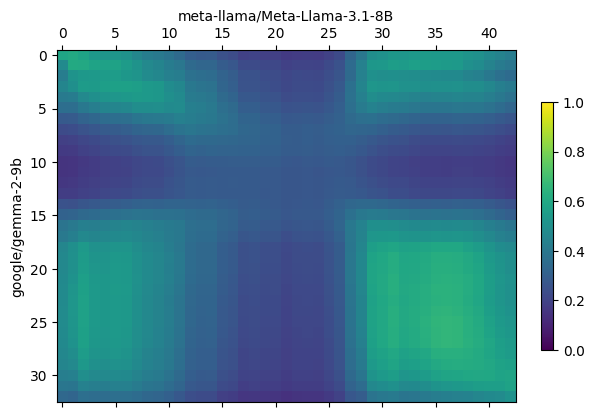

In [19]:
knn_1 = model_dataset_knn("meta-llama/Meta-Llama-3.1-8B", "random_strings")
knn_2 = model_dataset_knn("google/gemma-2-9b", "random_strings")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn, model_1="google/gemma-2-9b", model_2="meta-llama/Meta-Llama-3.1-8B")
plt.show()

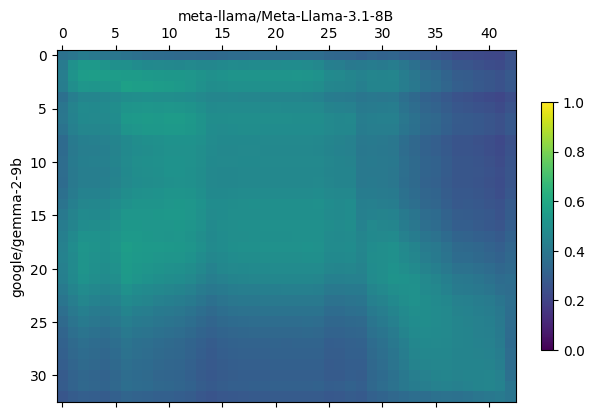

In [18]:
knn_1 = model_dataset_knn("meta-llama/Meta-Llama-3.1-8B", "common_words")
knn_2 = model_dataset_knn("google/gemma-2-9b", "common_words")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn, model_1="google/gemma-2-9b", model_2="meta-llama/Meta-Llama-3.1-8B")
plt.show()

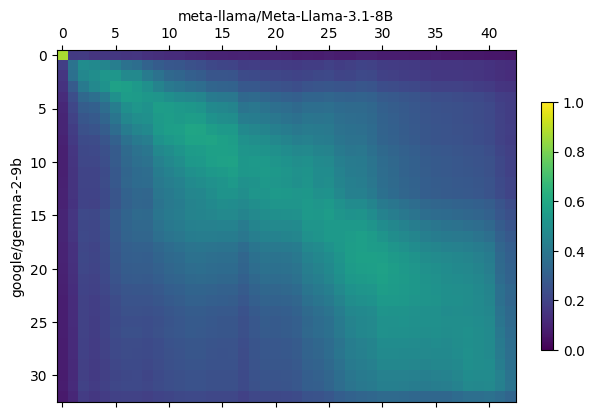

In [15]:
knn_1 = model_dataset_knn("meta-llama/Meta-Llama-3.1-8B", "web_text")
knn_2 = model_dataset_knn("google/gemma-2-9b", "web_text")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn, model_1="google/gemma-2-9b", model_2="meta-llama/Meta-Llama-3.1-8B")
plt.show()

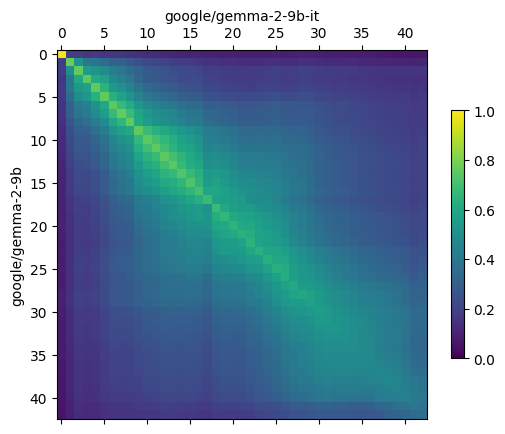

In [16]:
knn_1 = model_dataset_knn("google/gemma-2-9b", "web_text")
knn_2 = model_dataset_knn("google/gemma-2-9b-it", "web_text")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn, model_1="google/gemma-2-9b", model_2="google/gemma-2-9b-it")
plt.show()

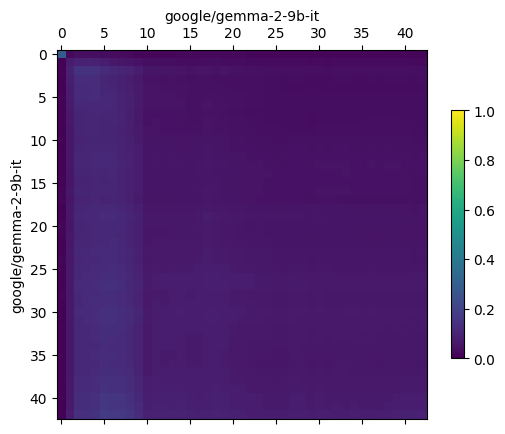

In [17]:
knn_1 = model_dataset_knn("google/gemma-2-9b-it", "web_text")
knn_2 = model_dataset_knn("google/gemma-2-9b-it", "web_text", use_chat_template=True)
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn, model_1="google/gemma-2-9b-it", model_2="google/gemma-2-9b-it")
plt.show()

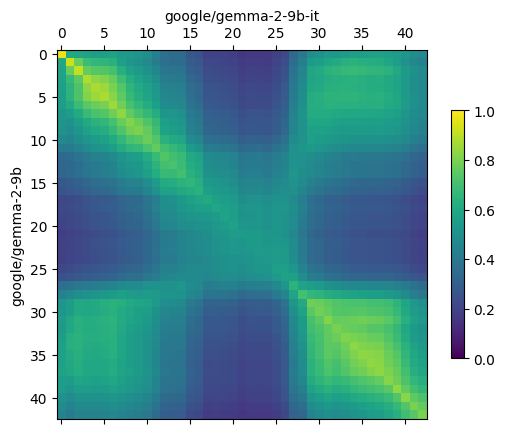

In [20]:
knn_1 = model_dataset_knn("google/gemma-2-9b", "random_strings")
knn_2 = model_dataset_knn("google/gemma-2-9b-it", "random_strings")
mknn = unireps.mutual_knn(knn_1, knn_2)
unireps.layer_by_layer_plot(mknn, model_1="google/gemma-2-9b", model_2="google/gemma-2-9b-it")
plt.show()

## Scratch space

In [3]:
model_names

['openai-community/gpt2',
 'google/gemma-2b',
 'google/gemma-7b',
 'google/gemma-2-2b',
 'google/gemma-2-9b',
 'google/gemma-2-9b-it',
 'google/gemma-2-27b',
 'meta-llama/Meta-Llama-3.1-8B',
 'meta-llama/Meta-Llama-3.1-8B-Instruct',
 'meta-llama/Llama-3.2-1B',
 'meta-llama/Llama-3.2-3B',
 'meta-llama/Llama-3.2-3B-Instruct',
 'meta-llama/Llama-3.2-11B-Vision',
 'mistralai/Mistral-7B-v0.3',
 'mistralai/Mistral-Nemo-Base-2407',
 'mistralai/Mixtral-8x7B-v0.1',
 'microsoft/Phi-3-mini-4k-instruct',
 'microsoft/Phi-3-medium-4k-instruct',
 'microsoft/Phi-3.5-mini-instruct',
 'tiiuae/falcon-40b',
 'tiiuae/falcon-11B',
 'meta-llama/Llama-3.1-70B',
 'meta-llama/Llama-3.1-70B-Instruct',
 'meta-llama/Llama-3.3-70B-Instruct',
 'tiiuae/falcon-mamba-7b']

In [6]:
model_dataset_knn("google/gemma-2-9b-it", "web_text")

tensor([[[ 941,  852,  671,  ...,    1,    4,    5],
         [   8,    4,   13,  ...,   19,   17,   12],
         [ 909,  135,  732,  ...,  391,  234,  769],
         ...,
         [   8,    4,    1,  ...,   18,   15,   12],
         [   8,    4,    1,  ...,   18,   15,   12],
         [   8,    4,    1,  ...,   18,   15,   12]],

        [[ 912,   27,  868,  ...,  320,  517,   48],
         [ 612,  931,  673,  ...,  961,  873,  387],
         [ 854,  334,  329,  ...,   97,  249,  337],
         ...,
         [ 963,  533,  795,  ...,  961,  305,  885],
         [  44,  258,  448,  ...,  637,  268,  102],
         [ 274,  635,  856,  ...,  667,  838,  273]],

        [[ 360,  962,  379,  ...,  428,  955,  357],
         [ 931,  673,  387,  ...,  509,  890,  612],
         [ 854,  329,  334,  ...,  541,   87,  561],
         ...,
         [ 963,  893,  305,  ...,  287,  873,  961],
         [  44,  690,  258,  ...,  932,  253,  448],
         [ 274,  382,  265,  ...,  635,  507,  525]],

In [ ]:
unireps.mutual_knn_layer_plot('google/gemma-2-9b', )

In [11]:
unireps.dataset_embs(unireps.get_dataset('google/gemma-2-9b', 'web_text'), layer=None).flatten().shape[0]

315621376

In [10]:
unireps.dataset_embs(unireps.get_dataset('google/gemma-2-9b', 'web_text'), layer=None).dtype

torch.float32

In [6]:
unireps.get_dataset('google/gemma-2-9b', 'web_text')['at_max_length'].sum()

tensor(0)

In [3]:
ds1 = unireps.get_dataset('google/gemma-2-9b', 'web_text')
knn_1 = unireps.embs_knn(unireps.dataset_embs(ds1), k=10)

In [4]:
ds2 = unireps.get_dataset('meta-llama/Meta-Llama-3.1-8B', 'web_text')
knn_2 = unireps.embs_knn(unireps.dataset_embs(ds2), k=10)

In [5]:
unireps.mutual_knn(knn_1[10], knn_2[8])

0.513134777545929

In [9]:
unireps.mutual_knn(knn_1, knn_2[8])

tensor([0.0831, 0.1569, 0.2169, 0.2207, 0.2527, 0.2982, 0.3617, 0.3904, 0.4087,
        0.4865, 0.5131, 0.5304, 0.5674, 0.5695, 0.5682, 0.5576, 0.5491, 0.4960,
        0.4822, 0.4681, 0.4539, 0.4306, 0.4163, 0.4173, 0.4065, 0.4018, 0.3722,
        0.3597, 0.3581, 0.3388, 0.3110, 0.2991, 0.2825, 0.2692, 0.2590, 0.2489,
        0.2453, 0.2361, 0.2302, 0.2268, 0.2138, 0.1868, 0.1689])

In [12]:
unireps.mutual_knn(knn_1[10], knn_2)

tensor([0.1092, 0.2494, 0.3223, 0.3869, 0.4757, 0.5337, 0.5438, 0.5401, 0.5131,
        0.4736, 0.4534, 0.4272, 0.4141, 0.3963, 0.3869, 0.3910, 0.3804, 0.3634,
        0.3356, 0.3242, 0.3117, 0.2981, 0.2833, 0.2706, 0.2563, 0.2474, 0.2460,
        0.2348, 0.2316, 0.2263, 0.2199, 0.2164, 0.1877])

In [15]:
a = unireps.mutual_knn(knn_1, knn_2)
a

tensor([[0.8828, 0.1515, 0.1325,  ..., 0.0655, 0.0663, 0.0607],
        [0.1518, 0.3474, 0.3457,  ..., 0.1095, 0.1116, 0.1003],
        [0.1511, 0.4600, 0.4422,  ..., 0.1699, 0.1732, 0.1602],
        ...,
        [0.0558, 0.1285, 0.1358,  ..., 0.4652, 0.4524, 0.3684],
        [0.0531, 0.1179, 0.1220,  ..., 0.4315, 0.4288, 0.3586],
        [0.0484, 0.1097, 0.1110,  ..., 0.3744, 0.3758, 0.3248]])

In [16]:
a[10,8]

tensor(0.5131)

In [2]:
embs_1 = unireps.dataset_embs(unireps.get_dataset('google/gemma-2-9b', 'web_text'), layer=None)

In [3]:
knn = unireps.embs_knn(embs_1, k=10)

In [5]:
knn_1 = unireps.embs_knn(embs_1[0], k=10)

In [10]:
knn[0] == knn_1

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [4]:
knn.shape

torch.Size([43, 2048, 10])

In [6]:
knn_1.shape

torch.Size([2048, 10])

In [7]:
embs_1.shape

torch.Size([43, 2048, 3584])

In [14]:
knn.dim()

3